In [1125]:
import pandas as pd
import numpy as np
import json5
import requests
import webbrowser
import datetime
import matplotlib.pyplot as plt

# global variables #

In [1126]:
# this defines today's date and month, which will be used later on
today_date = pd.to_datetime(pd.to_datetime("today").strftime('%Y-%m-%d'))
today_month = today_date.to_period('M')
print("today's date is: " + str(today_date) + "\n" + "today's month is: " + str(today_month))

today's date is: 2020-05-18 00:00:00
today's month is: 2020-05


# account attributes #

In [1127]:
# get client id and secret from https://www.strava.com/settings/api
client_id = [ENTER CLIENT ID]
client_secret = [ENTER CLIENT SECRET]

# get athelete id from going to https://www.strava.com/dashboard, clicking on "My Profile",
# and grabbing the number from the url
athlete_id = [ENTER ATHLETE ID]

# api setup and  management #

In [1128]:
# api request components
base = 'https://www.strava.com/api/v3/'
request_type_profile = 'athletes'
request_type_activies = 'athlete/activities'

#### run this to open authentication page and get code to exchange access token with higher permissions ####

In [1129]:
# h/t to the author of this post: https://yizeng.me/2017/01/11/get-a-strava-api-access-token-with-write-permission/
url_get_code = 'http://www.strava.com/oauth/authorize?client_id=' + str(client_id) + '&response_type=code&redirect_uri=http://localhost/exchange_token&approval_prompt=force&scope=profile:read_all,activity:read_all'
webbrowser.open(url_get_code)

True

#### after reading and agreeing to the terms, hit "Authorize". in the url, copy the alphanumeric string (i.e, the code) between "code=" and "&scope" paste the code in the below cell where instructed ####

In [ ]:
%%bash
curl -X POST https://www.strava.com/api/v3/oauth/token \
  -d client_id=[ENTER CLIENT ID] \
  -d client_secret=[ENTER CLIENT SECRET] \
  -d code=[ENTER CODE] \
  -d grant_type=authorization_code

#### copy the alphanumeric string following "access_token": in the above output paste the access token below ####

In [1131]:
access_token = [ENTER ACCESS TOKEN]

# get profile info#

In [ ]:
# profile url
url_profile = base + request_type_profile + '/' +  athlete_id + '/?access_token=' + access_token
print(url_profile)

In [ ]:
# run this to get your profile info
response_profile = json5.loads(requests.get(url_profile).text)
response_profile

# activities #

In [ ]:
# activites url
result_limit = '&per_page=50'
url_activites = base + request_type_activies + '/?access_token=' + access_token + result_limit
print(url_activites)

In [1135]:
# this pulls the activity data
# h/t to this article for a helpful framework on constructing the below loop
# http://www.hainke.ca/index.php/2018/08/23/using-the-strava-api-to-retrieve-activity-data/

# create empty df to store activity data
activities = pd.DataFrame()

# start page count incrementing variable
page = 1

while True:
    
    # get page of activities from Strava
    url = url_activites + '&page=' + str(page)
    r = pd.read_json(url)

    # if no results then exit loop
    if len(r) == 0:
        break
    
    # otherwise add new data to dataframe
    activities = pd.concat([activities,r], ignore_index=True)

    # increment page
    page += 1

# preview columns in the output (just showing the first 20)
for i in activities.columns[0:20]:
    print(i)

resource_state
athlete
name
distance
moving_time
elapsed_time
total_elevation_gain
type
workout_type
id
external_id
upload_id
start_date
start_date_local
timezone
utc_offset
start_latlng
end_latlng
location_city
location_state


In [1136]:
# rename distance column to be explcit about measurement unit
activities.rename(columns = {'distance':'distance_klm'},inplace = True)

# unit conversions
activities['distance_klm'] = activities['distance_klm'] / 1000
activities['distance_miles'] = activities['distance_klm'] / 1.60934 # klm -> miles conversion rate

activities['time_seconds'] = activities['moving_time']
activities['time_minutes'] = activities['time_seconds'] / 60
activities['time_hours'] = activities['time_minutes'] / 60

# datetime parsing
activities['activity_date'] = pd.to_datetime(activities['start_date']).dt.strftime('%Y-%m-%d')

# select only the desired columns
cols = ['activity_date','distance_miles','time_hours','time_minutes']
activities = activities[cols]

# preview results
activities.head()

,activity_date,distance_miles,time_hours,time_minutes
0,2020-05-17,1.510930,0.228611,13.716667
1,2020-05-17,5.305405,0.767778,46.066667
2,2020-05-15,2.325922,0.334722,20.083333
3,2020-05-13,2.514447,0.353611,21.216667
4,2020-05-12,2.079735,0.266389,15.983333


# dataframe construction #

In [1137]:
# create list of every date in the year in YYYY-MM-DD format
date_series = pd.date_range(start ='2020-01-01',  end = '2020-12-31', freq ='1D') 

# preview results
date_series[0:5]

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05'],
              dtype='datetime64[ns]', freq='D')

In [1138]:
# create list of every date's month in YYYY-MM format
month_series = date_series.to_period('M')

# preview results
month_series.unique()

PeriodIndex(['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12'],
            dtype='period[M]', freq='M')

In [1139]:
# create list of integers representing the day of the month (i.e. 2020-02-01 will have a value of 1, etc.)
month_day = date_series.day

# preview results
month_day[0:40]

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,
             4,  5,  6,  7,  8,  9],
           dtype='int64')

In [1140]:
# create list of integers representing the day of the year (i.e. 2020-02-01 will have a value of 32. etc.)
year_day = np.arange(len(date_series))
year_day = year_day + 1 # make first day of the year 1, not 0

# preview results
year_day[0:40]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

In [1143]:
# create dataframe with the lists created above
df = pd.DataFrame(list(zip(date_series,month_series,year_day,month_day)), columns =['date','month','year_day','month_day'])

# preview results
df.head()

,date,month,year_day,month_day
0,2020-01-01,2020-01,1,1
1,2020-01-02,2020-01,2,2
2,2020-01-03,2020-01,3,3
3,2020-01-04,2020-01,4,4
4,2020-01-05,2020-01,5,5


## daily performance ##
#### some days have multiple activities, so here we aggregate activities by day ####

In [1144]:
# aggregate activities by day
df_daily = activities.groupby('activity_date').sum().reset_index()

# calculate total runs per day
df_daily['runs'] = activities.groupby('activity_date').count().reset_index()['distance_miles']

# rename activity_date to date
df_daily.rename(columns = {'activity_date':'date'}, inplace = True)

# datetime parsing
df_daily['date'] = pd.to_datetime(df_daily['date'])

# preview results
df_daily.head()

,date,distance_miles,time_hours,time_minutes,runs
0,2020-01-03,2.000075,0.283333,17.0,2
1,2020-01-08,1.000037,0.133333,8.0,1
2,2020-01-14,1.000037,0.133333,8.0,1
3,2020-01-18,1.000037,0.150000,9.0,1
4,2020-01-20,1.000037,0.133333,8.0,1


In [1145]:
# combine the original dataframe with date information (df) with the daily perfomance dataframe (df_daily)
df = df.merge(df_daily, how = 'left', left_on = 'date', right_on = 'date')

# preview results (NaN indicates that there were no activitie sthat day)
df.head()

,date,month,year_day,month_day,distance_miles,time_hours,time_minutes,runs
0,2020-01-01,2020-01,1,1,NaN,NaN,NaN,NaN
1,2020-01-02,2020-01,2,2,NaN,NaN,NaN,NaN
2,2020-01-03,2020-01,3,3,2.000075,0.283333,17.0,2.0
3,2020-01-04,2020-01,4,4,NaN,NaN,NaN,NaN
4,2020-01-05,2020-01,5,5,NaN,NaN,NaN,NaN


In [1146]:
### add cumulative fields to the dataframe

# distance
df['cum_runs_year'] = df.fillna(0)['runs'].cumsum()
df['cum_distance_miles_year'] = df.fillna(0)['distance_miles'].cumsum()
df['cum_distance_miles_month'] = df.fillna(0).groupby(['month'])['distance_miles'].cumsum()

# time
df['cum_hours_month'] = df.fillna(0).groupby(['month'])['time_hours'].cumsum()
df['cum_hours_year'] = df['time_hours'].cumsum()

# inspect summary statistics of the dataframe (this is a way to notice any outliers)
df.describe().transpose() # easier to view transposed

,count,mean,std,min,25%,50%,75%,max
year_day,366.0,183.500000,105.799338,1.000000,92.250000,183.500000,274.750000,366.000000
month_day,366.0,15.756831,8.823592,1.000000,8.000000,16.000000,23.000000,31.000000
distance_miles,46.0,3.260424,3.080804,0.500019,1.099193,2.083649,4.024631,13.102452
time_hours,46.0,0.469010,0.464852,0.066667,0.155556,0.288889,0.563403,1.925833
time_minutes,46.0,28.140580,27.891144,4.000000,9.333333,17.333333,33.804167,115.550000
runs,46.0,1.173913,0.383223,1.000000,1.000000,1.000000,1.000000,2.000000
cum_runs_year,366.0,42.636612,17.623511,0.000000,34.000000,54.000000,54.000000,54.000000
cum_distance_miles_year,366.0,117.114292,50.493741,0.000000,83.021114,149.979495,149.979495,149.979495
cum_distance_miles_month,366.0,7.348620,11.412051,0.000000,0.000000,0.000000,13.102452,42.370226
cum_hours_month,366.0,1.059548,1.656620,0.000000,0.000000,0.000000,1.925556,6.118056


# Tracking my 2020 progress #

### cumulative distance run by day vs daily requirement to meet goal of 366 miles at end of year ###

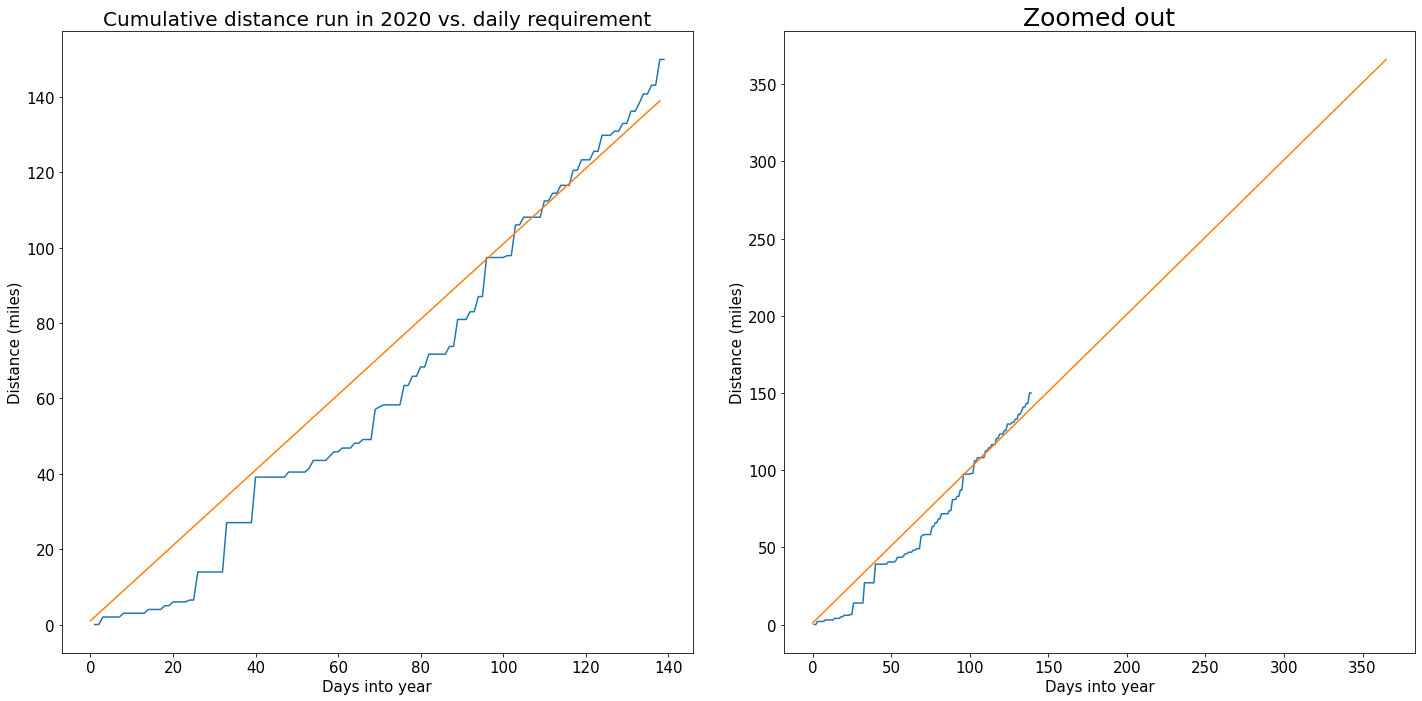

In [1148]:
# chart formatting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# filter for just dates that have happened
df_plot_1a = df[df['date'] <= today_date]

df_plot_1b = df
df_plot_1b.loc[df_plot_1b.date > today_date, 'cum_distance_miles_year'] = np.nan

# grab just the series we need
x1 = df_plot_1a[['year_day']]
y1 = df_plot_1a[['cum_distance_miles_year']]

x2 = df_plot_1b[['year_day']]
y2 = df_plot_1b[['cum_distance_miles_year']]

# plots
axes[0].plot(x1, y1, x1)
axes[1].plot(x2, y2, x2)

# chart title
axes[0].set_title('Cumulative distance run in 2020 vs. daily requirement', size = 20)
axes[1].set_title('Zoomed out', size = 25)

# axis titles
for ax in axes.flat:
    ax.set(xlabel='Days into year', ylabel='Distance (miles)')

fig.tight_layout()

### month over month cumulative distance run by day ###

In [1150]:
# filter for just dates that have happened
df_plot_2 = df[df['date'] <= today_date]

# grab just the columns we need
df_plot_2 = df_plot_2[['month','month_day','cum_distance_miles_month']]

# manipulate dataset to fit plot format
df_plot_2 = df_plot_2.pivot(index = 'month_day', columns = 'month', values = 'cum_distance_miles_month')

# preview results
df_plot_2.head()

month,2020-01,2020-02,2020-03,2020-04,2020-05
month_day,,,,,
1,0.000000,0.000000,0.992208,2.048355,2.271179
2,0.000000,13.102452,0.992208,2.048355,2.271179
3,2.000075,13.102452,0.992208,6.079014,6.512794
4,2.000075,13.102452,2.271242,6.079014,6.512794
5,2.000075,13.102452,2.271242,16.441088,6.512794


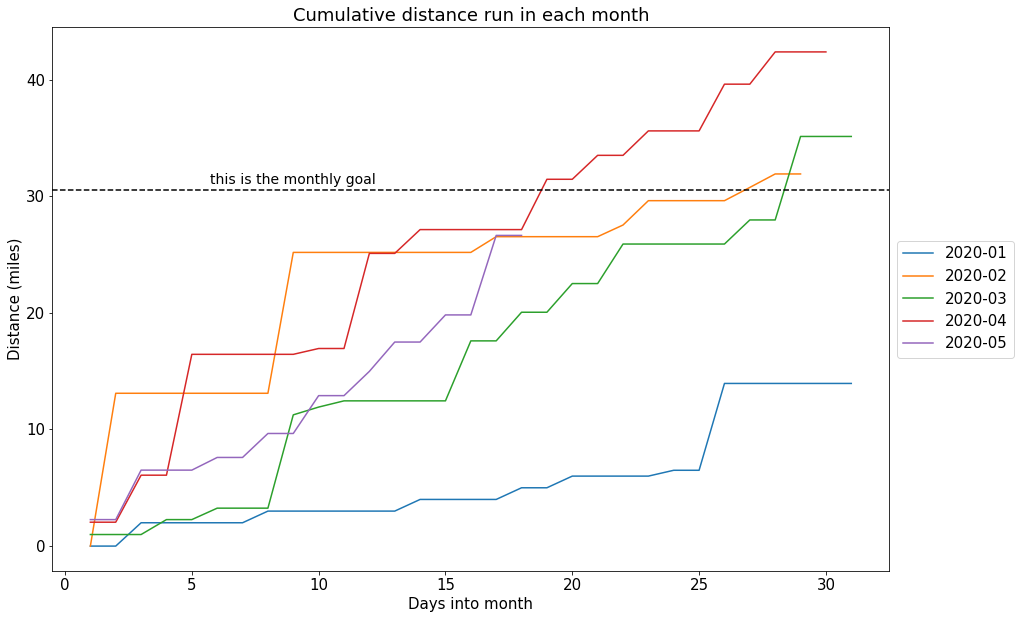

In [1151]:
# plot the whole dataset created above
df_plot_2.plot()

# chart formatting
plt.rcParams["figure.figsize"] = (15,10)

# add monthly goal line to chart
plt.axhline(y=30.5, color='black', linestyle='--') # 366 miles / 12 months = 30.5 miles per month
# add text above line
plt.text(9, 32, 'this is the monthly goal',
         rotation=0,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center',
         size=14)

# x axis
plt.xlabel('Days into month')
# y axis
plt.ylabel('Distance (miles)')
# chart title
plt.title('Cumulative distance run in each month')
# set text size
plt.rc('font', size=15)
# move legend to right of the chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# monthly metrics summary #

In [1152]:
# create dataframe, for now with just a column for month
df_monthly = df[['month']].drop_duplicates().reset_index().drop(columns = 'index')

# filter for just months that have started
df_monthly = df_monthly.loc[df_monthly.month <= today_month,:]

# preview results
df_monthly.head()

,month
0,2020-01
1,2020-02
2,2020-03
3,2020-04
4,2020-05


In [1153]:
# this will add more features to the dataframe

for i in range(len(df_monthly['month'])):

    # decalre month #
    month = df_monthly.iloc[i]['month']
    
    ### monthly stats ###
    
    df_monthly.loc[i,'total_runs'] = df[df['month'] == month][['runs']].sum().values
    
    df_monthly.loc[i,'total_distance'] = df[df['month'] == month][['distance_miles']].sum().values
    df_monthly.loc[i,'longest_run_distance'] = df[df['month'] == month][['distance_miles']].max().values
    
    df_monthly.loc[i,'total_hours'] = df[df['month'] == month][['time_hours']].sum().values
    df_monthly.loc[i,'total_minutes'] = df[df['month'] == month][['time_minutes']].sum().values
    df_monthly.loc[i,'longest_run_hours'] = df[df['month'] == month][['time_hours']].max().values
    
    df_monthly.loc[i,'cum_runs_month_end'] = df[df['month'] == month][['cum_runs_year']].max().values
    df_monthly.loc[i,'cum_distance_month_end'] = df[df['month'] == month][['cum_distance_miles_year']].max().values
    df_monthly.loc[i,'cum_hours_month_end'] = df[df['month'] == month][['cum_hours_year']].max().values
    
    ### per day stats ###

    df_monthly.loc[i,'avg_distance_per_day'] = df[df['month'] == month][['distance_miles']].fillna(0).mean().values
    df_monthly.loc[i,'avg_minutes_per_day'] = df[df['month'] == month][['time_minutes']].fillna(0).mean().values
    
    ### per run stats ###
    
    df_monthly.loc[i,'avg_distance_per_run'] = df[df['month'] == month][['distance_miles']].mean().values
    df_monthly.loc[i,'avg_minutes_per_run'] = df[df['month'] == month][['time_minutes']].mean().values   

In [1154]:
# create pace variable
df_monthly['pace'] = df_monthly['total_minutes'] / df_monthly['total_distance']

In [1155]:
# reorder the dataframe's columns by metric (distance, time, etc.)
col_order = ['month','total_runs','cum_runs_month_end','total_distance','cum_distance_month_end', \
             'longest_run_distance','avg_distance_per_run','avg_distance_per_day','total_hours', \
             'cum_hours_month_end','longest_run_hours','avg_minutes_per_run','avg_minutes_per_day','pace']

df_monthly = df_monthly[col_order]
df_monthly.transpose() # easier to view transposed

,0,1,2,3,4
month,2020-01,2020-02,2020-03,2020-04,2020-05
total_runs,8,9,16,11,10
cum_runs_month_end,8,17,33,44,54
total_distance,13.9452,31.9064,35.1212,42.3702,26.6365
cum_distance_month_end,13.9452,45.8516,80.9728,123.343,149.979
longest_run_distance,7.44492,13.1025,8.00005,10.3621,6.81633
avg_distance_per_run,1.99217,4.55806,2.92676,3.85184,2.95961
avg_distance_per_day,0.449844,1.10022,1.13294,1.41234,0.859242
total_hours,1.92556,4.7775,5.05583,6.11806,3.6975
cum_hours_month_end,1.92556,6.70306,11.7589,17.8769,21.5744


#### we can visualize the above stats. let's look at total distance and pace, for example ####

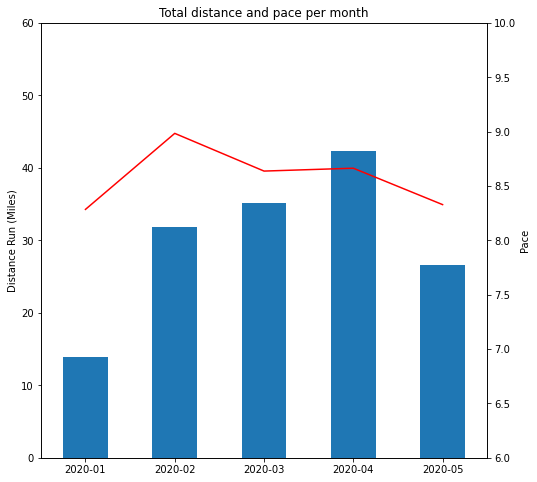

In [1159]:
# chart formatting
plt.rcParams["figure.figsize"] = (8,8)

# chart title
plt.title('Total distance and pace per month')

# y1 axis
df_plot_1['total_distance'].plot(kind='bar')
plt.ylim(0, 60)
plt.ylabel('Distance Run (Miles)')

# y2 axis
df_plot_1['pace'].plot(secondary_y=True, color = 'red')
plt.ylim(6, 10)
plt.ylabel('Pace')

# x axis
months = df_plot['month']
y_pos = np.arange(len(months))
plt.xticks(y_pos, months)
plt.xlabel('Month')

plt.rc('font', size=10)